# Ensemble Methods

**TODO: Mention continuation of presentation**

**TODO: Link slides**

## Overview

**TODO: Mention using scikit-learn for basic algorithms, hyperparameter tuning them, then using additional frameworks**

## Setup

**TODO: Talk about what is being set up and why**

In [1]:
# TODO: Trim out any of these that aren't used

import sys
import time
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn import ensemble
from sklearn import linear_model
from sklearn import metrics

print(time.strftime('%Y/%m/%d %H:%M'))
print('OS:', sys.platform)
print('Python:', sys.version)
print('NumPy:', np.__version__)
print('Pandas:', pd.__version__)

# Formatting for seaborn plots
sns.set_context('notebook', font_scale=1.1)
sns.set_style('ticks')

# Displays all dataframe columns
pd.set_option('display.max_columns', None)

%matplotlib inline

2018/07/01 13:53
OS: win32
Python: 3.5.5 | packaged by conda-forge | (default, Apr  6 2018, 16:03:44) [MSC v.1900 64 bit (AMD64)]
NumPy: 1.12.1
Pandas: 0.23.1


Creating an artificial data set

In [70]:
# Creating an artificial dataset to test algorithms on
data = datasets.make_classification(n_samples=10000,
                                    n_features=20,
                                    n_redundant=10,  # Superfluous features working as noise for the algorithms
                                    n_classes=2,
                                    random_state=46)

# Assigning features/labels to variables for ease of use
X = data[0]
y = data[1]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=46)

# Putting into a dataframe for viewing
df = pd.DataFrame(X)
df['label'] = y

df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,label
0,-0.343920,2.183724,-0.329355,0.726638,0.957844,0.608154,0.694615,-0.605511,-0.455621,0.176618,-1.124230,-0.865299,0.570698,-0.153149,-1.091536,0.234417,0.721312,0.547745,-0.289200,-1.191409,1
1,0.774190,-2.016869,-0.021031,-0.906889,-0.029434,-0.441084,0.107174,0.855932,-0.935103,0.362387,0.213634,1.057745,-1.475432,0.947640,0.656730,1.404927,0.969326,-0.394462,1.108383,0.895234,1
2,0.374310,-0.526407,-0.014263,-0.616020,-0.532336,-0.439311,-0.355215,0.537372,0.025556,0.975785,0.667766,0.728247,-0.666881,0.484163,0.938401,0.164457,-0.163050,0.033533,0.671236,0.868102,1
3,-0.467427,-1.104554,0.197691,0.361233,-0.525898,0.029103,-0.491823,-0.387143,1.065813,0.591295,0.463344,-0.411085,0.939574,0.309666,0.261822,-1.052417,-1.248117,0.424516,0.139155,-0.083763,1
4,1.249810,0.070364,0.025214,-1.091843,1.038544,-0.238204,1.026244,1.122799,-2.510867,0.220845,-0.838387,1.253015,-2.479266,-1.013690,-1.001703,1.343505,2.889017,1.069103,0.163846,0.532796,0


**TODO: Talk about creating this function for gathering results**

In [72]:
# Data frame for gathering results 
results = pd.DataFrame(columns=['Accuracy', 'LogLoss', 'TrainingTime'])
tuned_results = results.copy()

# Function for training a model and retrieving the results
def train_model_get_results(model, model_name):
    '''
    Trains a model and appends the results to the results dataframe
    
    Input:
        - model: The model with specified hyperparameters to be trained
        - model_name: The name of the model to be used as the index
        - is_tuned: A binary flag for if hyperparameter tuning has been performed
    
    Output: The results dataframe with the model results added
    
    Note: Only works with scikit-learn models
    '''
    
    # Collecting training time for results
    start_time = time.time()
    
    print('Training the model')
    model.fit(X_train, y_train)
    
    end_time = time.time()
    total_training_time = end_time - start_time
    print('Completed')
    
    # Calculating the testing set accuracy with the score method
    accuracy = model.score(X_test, y_test)
    
    # Calcuating the log loss with predicted probabilities
    class_probabilities = model.predict_proba(X_test)
    log_loss = metrics.log_loss(y_test, class_probabilities)
    
    # Adding the model results to the results dataframe
    model_results = [accuracy, log_loss, total_training_time]
    results.loc[model_name] = model_results
    
    print('\n', 'Non-tuned results:')
    return results

## Baseline

It's always useful to have a baseline to compare against. I like to use linear/logistic regression due to them being extremely fast to train.

**TODO:** Say something about wanting to be better than random chance or something

In [73]:
# Instantiating the model
logistic_regression = linear_model.LogisticRegression()

# Using our user defined function to train the model and return the results
train_model_get_results(model=logistic_regression, model_name='Logistic Regression')

Training the model
Completed

 Non-tuned results:


,Accuracy,LogLoss,TrainingTime
Logistic Regression,0.899333,0.245198,0.046748


## Bagging

Bagging (bootstrap aggregating) is the technique that aggregates models built with bootstrapping, or sampling with replacement. 

The most popular bagging algorithm is the **random forest**. This algorithm works by building a series of decision trees where each tree uses a random selection of variables, and then decision trees vote on the final answer.  **TODO: Improve this explanation**

<img src="http://www.globalsoftwaresupport.com/wp-content/uploads/2018/02/ggff5544hh.png">

**Advantages:**
- Robustness against over-fitting
    - Since the model is created through dense randomness, the generalization is typically better, and you can usually increase the accuracy with the number of trees up until a saturation point
- Soft thresholding (boundaries) on the instance space.
- Able to parallelize training multiple trees at once and thus speed up training time

In [74]:
random_forest = ensemble.RandomForestClassifier(n_jobs=-1)  # n_jobs=-1 uses all available cores

train_model_get_results(random_forest, model_name='Random Forest')

Training the model
Completed

 Non-tuned results:


,Accuracy,LogLoss,TrainingTime
Logistic Regression,0.899333,0.245198,0.046748
Random Forest,0.975333,0.373645,0.250003


## Boosting

**TODO: Describe what boosting is**

**TODO: Explain AdaBoost, how it works, and its advantages**

In [76]:
adaptive_boosting = ensemble.AdaBoostClassifier()

train_model_get_results(adaptive_boosting, model_name='AdaBoost')

Training the model
Completed

 Non-tuned results:


,Accuracy,LogLoss,TrainingTime
Logistic Regression,0.899333,0.245198,0.046748
Random Forest,0.975333,0.373645,0.250003
AdaBoost,0.968667,0.634736,1.577889


**TODO: Explain gradient boosting, how it works, and its advantages**

In [77]:
gradient_boosting = ensemble.GradientBoostingClassifier()

train_model_get_results(gradient_boosting, model_name='Gradient Boosted Trees')

Training the model
Completed

 Non-tuned results:


,Accuracy,LogLoss,TrainingTime
Logistic Regression,0.899333,0.245198,0.046748
Random Forest,0.975333,0.373645,0.250003
AdaBoost,0.968667,0.634736,1.577889
Gradient Boosted Trees,0.973667,0.100621,2.171741


## Stacking

**TODO: Explain stacking, how it works, and its advantages/disadvantages**

**TODO: Include a picture for stacking**

**TODO: Check if there's a better way to do stacking w/ scikit-learn**

**TODO: Check if there's a way to avoid repeating fit/predict lines**

In [24]:
from sklearn import neighbors

# Defining the learners for the first layer
model_1 = linear_model.LogisticRegression()
model_2 = ensemble.RandomForestClassifier(n_jobs=-1)
model_3 = neighbors.KNeighborsClassifier(n_jobs=-1)

# The meta learner is the one that takes the outputs from the other models as input before final classification
meta_learner = linear_model.LogisticRegression()

# Collecting training time for results
start_time = time.time()
print('Training the model')

# Fitting the first layer models
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)

model_1_train_output = model_1.predict_proba(X_train)[:, 1]
model_2_train_output = model_2.predict_proba(X_train)[:, 1]
model_3_train_output = model_3.predict_proba(X_train)[:, 1]

X_train_meta = np.hstack((model_1_train_output.reshape(-1, 1),
                          model_2_train_output.reshape(-1, 1),
                          model_2_train_output.reshape(-1, 1)))

meta_learner.fit(X_train_meta, y_train)

end_time = time.time()
total_time = end_time - start_time
print('Completed')

model_1_test_output = model_1.predict_proba(X_test)[:, 1]
model_2_test_output = model_2.predict_proba(X_test)[:, 1]
model_3_test_output = model_3.predict_proba(X_test)[:, 1]

X_test_meta = np.hstack((model_1_test_output.reshape(-1, 1),
                         model_2_test_output.reshape(-1, 1),
                         model_2_test_output.reshape(-1, 1)))

accuracy = meta_learner.score(X_test_meta, y_test)

# Calcuating the log loss with predicted probabilities
class_probabilities = meta_learner.predict_proba(X_test_meta)
log_loss = metrics.log_loss(y_test, class_probabilities)

model_results = [accuracy, log_loss, total_time]

results.loc['Stacking'] = model_results

results

Training the model
Completed


,Accuracy,LogLoss,TrainingTime
Logistic Regression,0.853111,0.355937,0.062496
Random Forest,0.863778,0.817025,0.359398
AdaBoost,0.872000,0.660321,2.374857
Stacking,0.856222,0.544093,4.171623


# Hyperparameter Tuning

There are a couple of methodologies for hyperparameter tuning. The first involvse 

**TODO: Talk about grid search vs. random search**

<img src="https://cdn-images-1.medium.com/max/923/1*ZTlQm_WRcrNqL-nLnx6GJA.png">

*Source: [James Bergstra & Yoshua Bengio](http://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf)*

**TODO: Talk about decision tree structure & hyperparameters**

https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters-Tuning.rst

For Faster Speed

    Use bagging by setting bagging_fraction and bagging_freq
    Use feature sub-sampling by setting feature_fraction
    Use small max_bin
    Use save_binary to speed up data loading in future learning
    Use parallel learning, refer to Parallel Learning Guide

For Better Accuracy

    Use large max_bin (may be slower)
    Use small learning_rate with large num_iterations
    Use large num_leaves (may cause over-fitting)
    Use bigger training data
    Try dart

Deal with Over-fitting

    Use small max_bin
    Use small num_leaves
    Use min_data_in_leaf and min_sum_hessian_in_leaf
    Use bagging by set bagging_fraction and bagging_freq
    Use feature sub-sampling by set feature_fraction
    Use bigger training data
    Try lambda_l1, lambda_l2 and min_gain_to_split for regularization
    Try max_depth to avoid growing deep tree


## Baseline

**TODO: Note about only tuning C and what it does**

Default Parameters: 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 

Beginning hyperparameter tuning
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.0s
[Paralle

Completed
Best estimator: 

LogisticRegression(C=7.8383235080575062, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

 Tuned results:


C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


,Accuracy,LogLoss,TrainingTime
Logistic Regression,0.906667,0.237161,3.609153


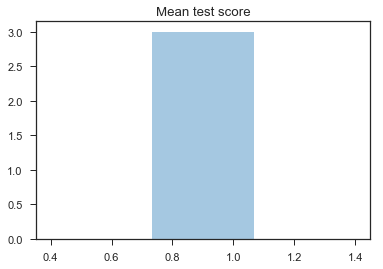

In [42]:
def random_search_get_results(model, parameters, model_name, num_rounds=10):
    '''
    TODO: Fill docstring
    '''
    
    print('Default Parameters:', '\n')
    print(model, '\n')
    
    random_search = RandomizedSearchCV(model,
                                       param_distributions=parameters,
                                       n_iter=num_rounds, n_jobs=-1,
                                       return_train_score=True, random_state=46,
                                       verbose=20)  # Prints status of each completed fit
    
    print('Beginning hyperparameter tuning')
    start_time = time.time()
    random_search.fit(X_train, y_train)
    end_time = time.time()
    total_training_time = end_time - start_time
    print('Completed')
    
    # Calculating the testing set accuracy on the best estimator with the score method
    accuracy = random_search.best_estimator_.score(X_test, y_test)
    
    # Calcuating the log loss with predicted probabilities
    class_probabilities = random_search.best_estimator_.predict_proba(X_test)
    log_loss = metrics.log_loss(y_test, class_probabilities)
    
    # Adding the model results to the results dataframe
    model_results = [accuracy, log_loss, total_training_time]
    tuned_results.loc[model_name] = model_results
    
    # Plotting the mean training accuracy from the different iterations
    sns.distplot(random_search.cv_results_['mean_test_score'])
    plt.title('Mean test score')
    
    print('Best estimator:', '\n')
    print(random_search.best_estimator_)
    
    print('\n', 'Tuned results:')
    return tuned_results


parameters = {'C': scipy.stats.uniform(0, 10)}  # Uniform distribution between 0 and 10

random_search_get_results(logistic_regression, parameters, 'Logistic Regression')

## Random Forests

**TODO: Explain random forest tuning strategies**

Use [this](https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/) as reference

Default Parameters: 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 

Beginning hyperparameter tuning
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   40.7s
[Paralle

Completed
Best estimator: 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=203, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

 Tuned results:


,Accuracy,LogLoss,TrainingTime
Logistic Regression,0.906667,0.237161,3.609153
Random Forest,0.975667,0.097956,65.723121


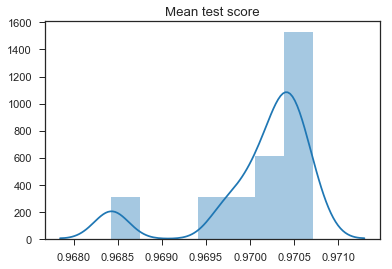

In [45]:
parameters = {'n_estimators': scipy.stats.randint(low=10, high=500),  # Uniform distribution between 10 and 750
              'max_features': ['auto', 'sqrt'],  # Number of features to consider at each split
              'max_depth': [None, 10, 30, 100],  # Maximum number of levels in a tree
              'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
              'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at each leaf node
#               'boostrap': [True, False]
             }  # If the samples should be bootstrapped or not
             

random_search_get_results(random_forest, parameters, 'Random Forest')

**TODO: Show more directed hyperparameter tuning given current data**

## Gradient Boosted Trees

**TODO: Explain GBT tuning strategies & how different components affect the model**

**TODO: Show more directed hyperparameter tuning given current data**

## Stacking

**TODO: Talk about how it's more ambiguous due to being a collection of several models**

# Additional Frameworks

**TODO: Talk about additional frameworks, their strengths/weaknesses/etc.**

### XGBoost

**TODO: Explain XGBoost, what it is, how it works, and why it's good**

**TODO: Explain how to install xgboost**

#### Hyperparameter Tuning

### LightGBM

**TODO: Explain LightGBM, what it is, how it differs from XGBoost, and why it's good**

**TODO: How to install LightGBM**

In [47]:
import lightgbm as lgb

lightGBM = lgb.LGBMClassifier(nthread=-1)  # nthread=-1 uses all available cores

# Due to the scikit-learn API option, LightGBM works with our function!
train_model_get_results(lightGBM, 'LightGBM')

Training the model
Completed

 Non-tuned results:


,Accuracy,LogLoss,TrainingTime
Logistic Regression,0.906667,0.237251,0.046874
Random Forest,0.973667,0.263248,0.265526
AdaBoost,0.965000,0.644167,1.546803
Gradient Boosted Trees,0.974000,0.092661,2.218480
LightGBM,0.975333,0.246272,0.109368


#### Hyperparameter Tuning

Default Parameters: 

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=10, nthread=-1,
        num_leaves=31, objective='binary', reg_alpha=0, reg_lambda=0,
        seed=0, silent=True, subsample=1, subsample_for_bin=50000,
        subsample_freq=1) 

Beginning hyperparameter tuning
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   12.0s
[Paralle

Completed
Best estimator: 

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=413, nthread=-1,
        num_leaves=31, objective='binary', reg_alpha=0, reg_lambda=0,
        seed=0, silent=True, subsample=1, subsample_for_bin=50000,
        subsample_freq=1)

 Tuned results:


,Accuracy,LogLoss,TrainingTime
Logistic Regression,0.906667,0.237161,3.609153
Random Forest,0.975667,0.097956,65.723121
LightGBM,0.972667,0.101834,24.951612


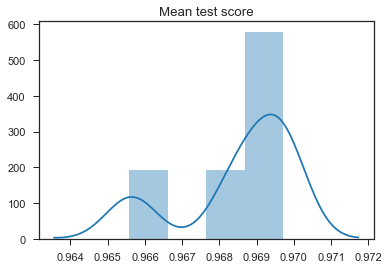

In [60]:
# parameters = {'n_estimators': scipy.stats.randint(low=10, high=500),  # Uniform distribution between 10 and 750
#               'max_features': ['auto', 'sqrt'],  # Number of features to consider at each split
#               'max_depth': [None, 10, 30, 100],  # Maximum number of levels in a tree
#               'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
#               'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at each leaf node
# #               'boostrap': [True, False]
#              }  # If the samples should be bootstrapped or not
             
parameters = {'boosting_type': ['gbdt', 'dart'],
              'n_estimators': scipy.stats.randint(low=10, high=500),  # Uniform distribution between 10 and 750
              'learning_rate': [0.01, 0.03, 0.1, 0.3],
#               'num_leaves': 31,
#               'max_depth': 1,
#               'max_bin': 255,
#               'reg_alpha': 0,  # L1 regularization
#               'reg_lambda': 0  # L2 regularization
             }    

random_search_get_results(lightGBM, parameters, 'LightGBM')

### h2o

**TODO: Explain h2o, why it's good, how it works, etc.**

**TODO: Installing h2o**

#### Hyperparameter Tuning